In [1]:
import os
# print(os.getcwd())

import warnings
warnings.filterwarnings('ignore') 

/home/piyushsamant/Data/MicroRNA cohort data by Jin u for Generative AI/Experiment with Ridge Model small miRNA set


In [10]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, ElasticNetCV, RidgeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score
from sklearn.datasets import make_classification
from keras.initializers import RandomNormal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Embedding, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import backend
from keras.backend import mean
from keras.optimizers import SGD




In [45]:
# Reading all 3 cohort dataset and combining them and normalizing them 
phase_1_data = pd.read_csv('../Data Only /Phase1_data_mirna.csv')
phase_2_data = pd.read_csv('../Data Only /Phase2_data_mirna.csv')
phase_3_data = pd.read_csv('../Data Only /Phase3_data_mirna.csv')

common_small_cluster = pd.read_csv('../Common_miRNA_small_cluster.csv')
common_small_cluster = common_small_cluster['Common miRNA form small cluster']

# Cohort 1 

phase_1  = phase_1_data[common_small_cluster.tolist() + ['Group']]
phase_1['Group'] = phase_1['Group'].apply(lambda x: 1 if x == 'CRC' else 0)
phase_1_value_count = phase_1['Group'].value_counts()
print(phase_1_value_count)
# Now Breaking features and target septrate
phase_1_X = phase_1.drop(columns='Group')
phase_1_y = phase_1['Group']

# Cohort 2 Data 
phase_2 = phase_2_data[common_small_cluster.tolist() + ['Group']]
phase_2['Group'] = phase_2['Group'].apply(lambda x: 1 if x == 'CRC' else 0)
phase_2_value_count = phase_2['Group'].value_counts()
print(phase_2_value_count)
# Now Breaking features and target septrate
phase_2_X = phase_2.drop(columns='Group')
phase_2_y = phase_2['Group']

# Cohort 3 
phase_3 = phase_3_data[common_small_cluster.tolist() + ['Group']]
phase_3['Group'] = phase_3['Group'].apply(lambda x: 1 if x == 'Cancer' else 0)
phase_3_value_count = phase_3['Group'].value_counts()
print(phase_3_value_count)
# Now Breaking features and target septrate
phase_3_X = phase_3.drop(columns='Group')
phase_3_y = phase_3['Group']


# # Now devide training and testing (this will be done if I want to have a final test dataset for last testing)
# X1, X1_final_test, y1, y1_final_test = train_test_split( phase_1_X, phase_1_y, test_size=0.20, random_state=42)

# X2, X2_final_test, y2, y2_final_test = train_test_split( phase_2_X, phase_2_y, test_size=0.20, random_state=42)

# X3, X3_final_test, y3, y3_final_test = train_test_split( phase_3_X, phase_3_y, test_size=0.20, random_state=42)



Group
0    590
1    210
Name: count, dtype: int64
Group
0    341
1    123
Name: count, dtype: int64
Group
0    107
1     50
Name: count, dtype: int64


In [46]:
# # combine all cohorts and targets in fataframe form  
X_pd = pd.concat([phase_1_X, phase_2_X, phase_3_X], axis = 0, ignore_index = True)
y_pd = pd.concat([phase_1_y, phase_2_y, phase_3_y], axis = 0, ignore_index = True)

data_value_count = y_pd.value_counts()
print(data_value_count)

scaler = StandardScaler()

# X = X_pd.values
X_original_norm = scaler.fit_transform(X_pd)
y_original_norm = y_pd.values

Group
0    1038
1     383
Name: count, dtype: int64


In [63]:
# Defineing the CGan Model and training process

# these libraries are already imported but to make a function later these libraries will be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Embedding, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.backend import mean
from keras.optimizers import SGD
from keras import backend


def wasserstein_loss(y_true, y_pred):
    return mean(y_true * y_pred)


class cGAN1():
    def __init__(self, latent_dim = 32, out_shape = 24):
        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer

        # Experiment with optimizer, learning rate, Beta1 
        # optimizer = Adam(0.00001, 0.5)
        optimizer = Adam(0.00001, 0.9)
        # optimizer = SGD(lr = 0.0001, momentum = 0.5, nesterov = True)

        # building the discriminator
        self.discriminator = self.discriminator()
        # self.discriminator.compile(loss=['binary_crossentropy'], optimizer = optimizer,metrics=['accuracy'])
        self.discriminator.compile(loss = wasserstein_loss, optimizer = optimizer, metrics = ['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        # self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer, metrics=['accuracy'])
        self.combined.compile(loss = wasserstein_loss, optimizer = optimizer, metrics = ['accuracy'])


        self.G_losses = []
        self.D_losses = []

    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name = "Discriminator")

    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size = 32, sample_interval = 100, plot=True):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size - 8)
                idx = np.concatenate((idx1, idx0))
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            if epoch < epochs // 1.5:
                valid_smooth = (valid + 0.1) - (np.random.random(valid.shape) * 0.1)
                fake_smooth = (fake - 0.1) + (np.random.random(fake.shape) * 0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch + 1) % sample_interval == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, epochs, d_loss[0], g_loss[0]))
            self.G_losses.append(g_loss[0])
            self.D_losses.append(d_loss[0])

            if plot:
                if epoch + 1 == epochs:
                    plt.figure(figsize=(3, 2))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(self.G_losses, label="G")
                    plt.plot(self.D_losses, label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()


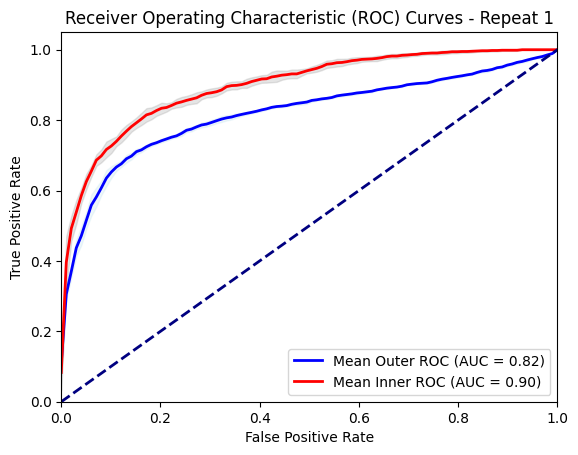

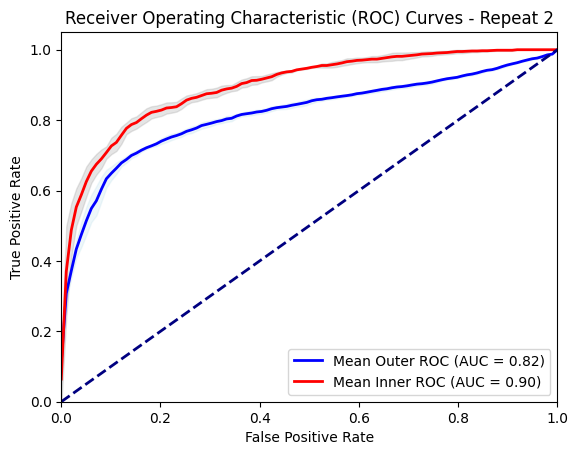

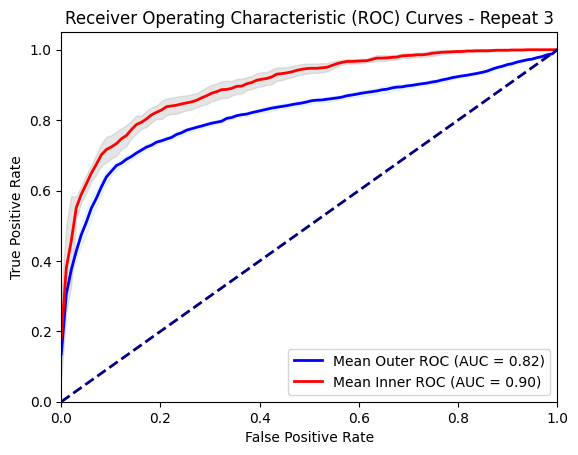

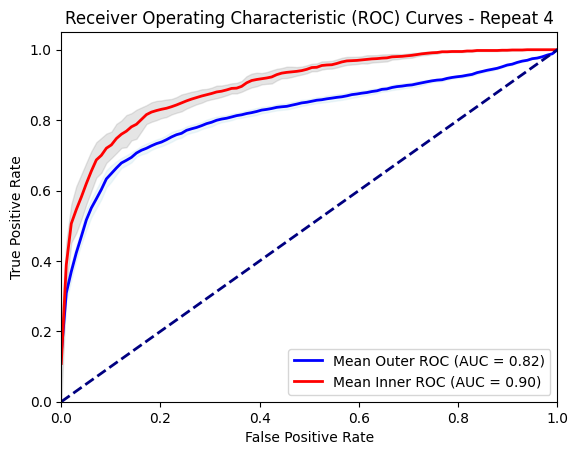

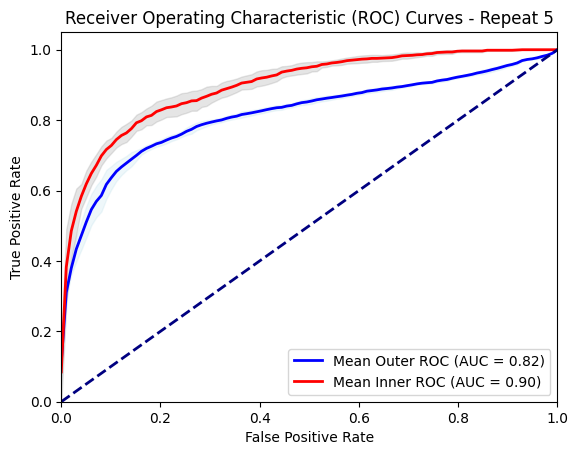

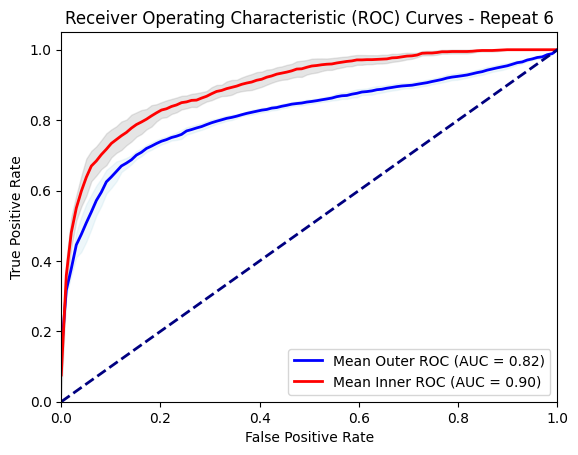

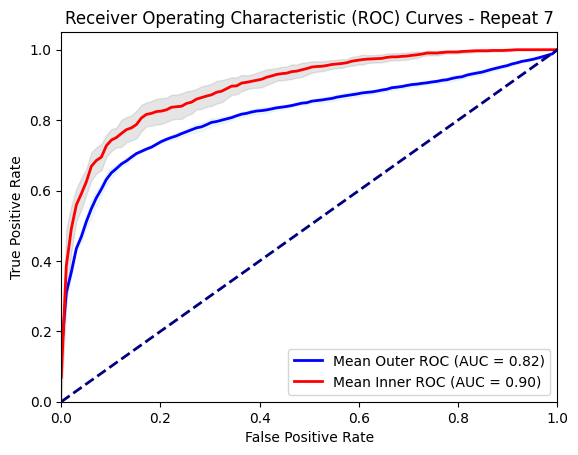

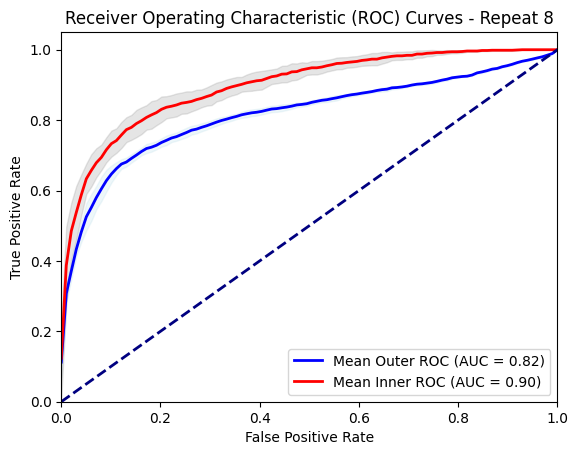

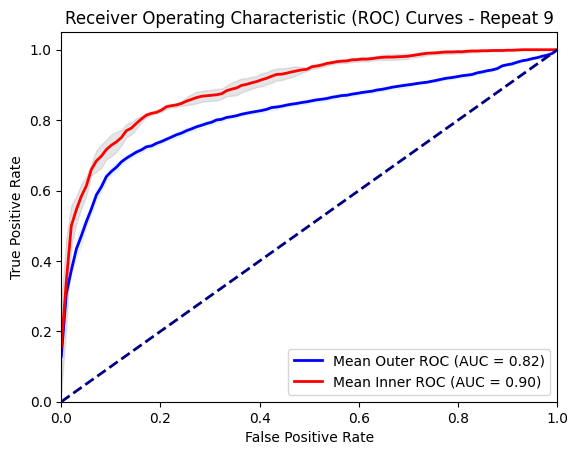

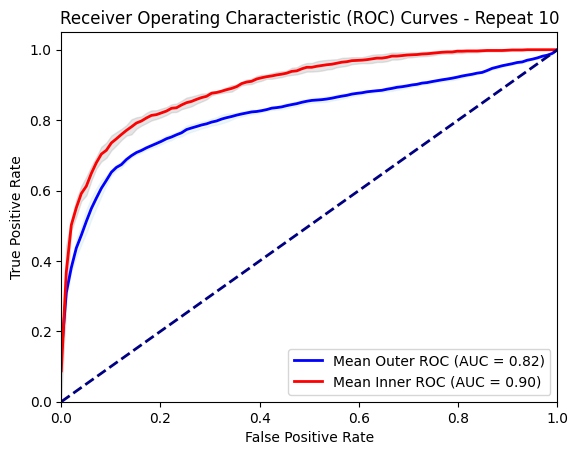

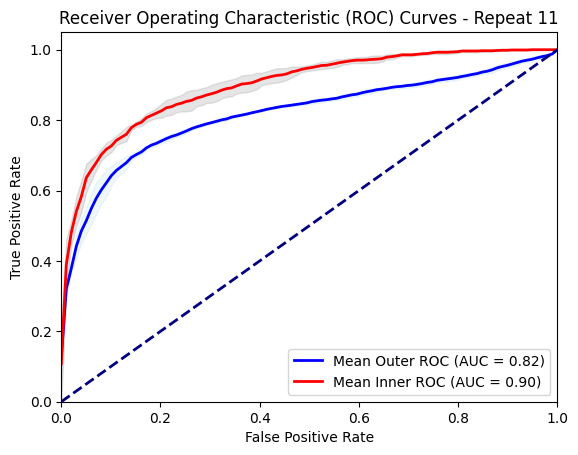

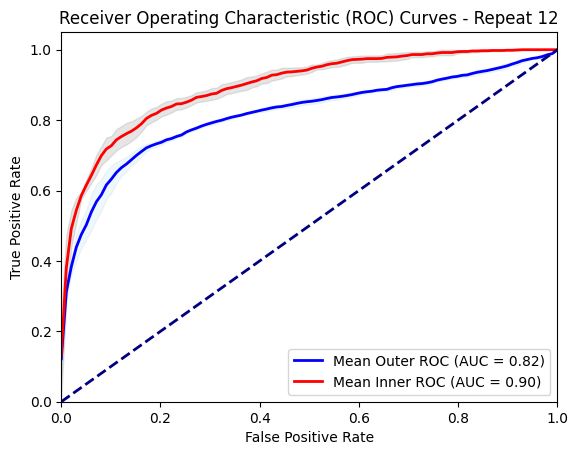

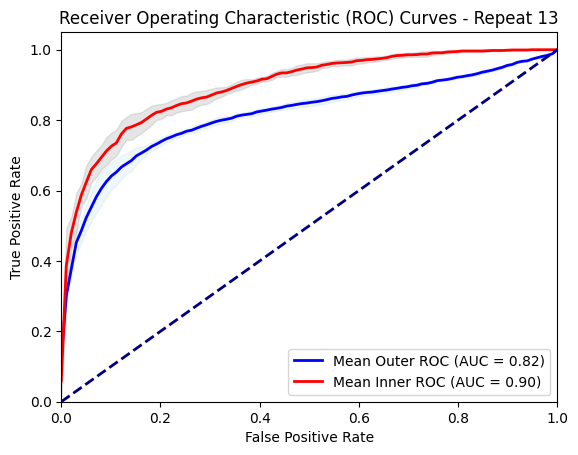

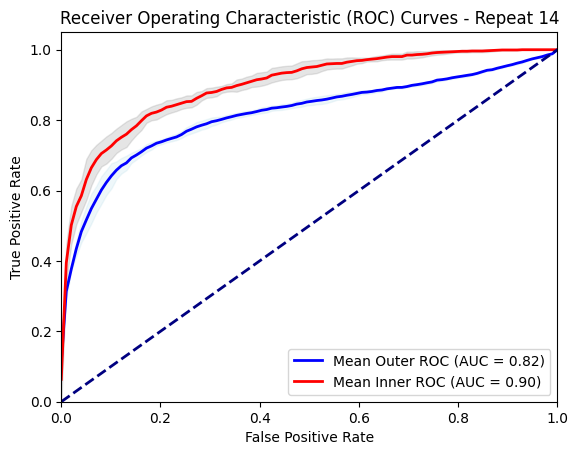

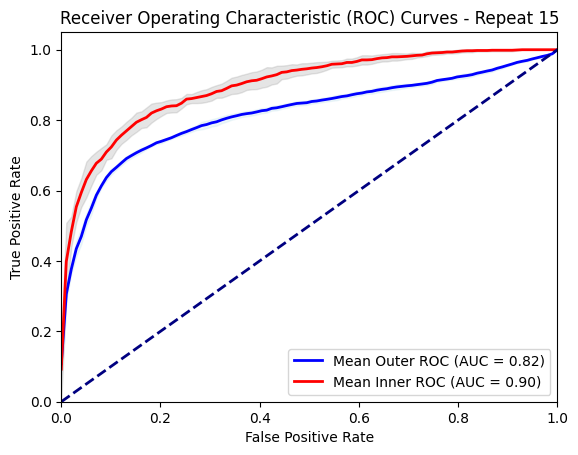

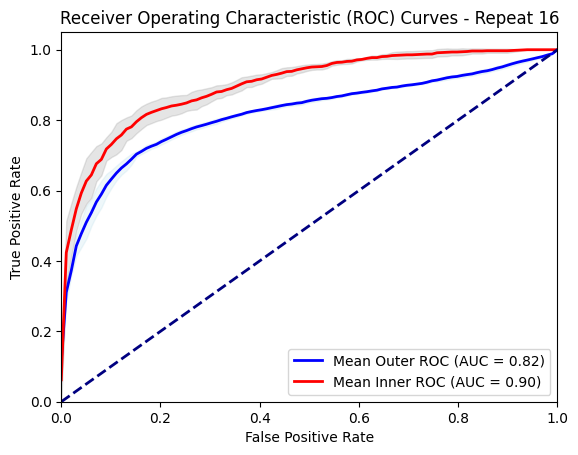

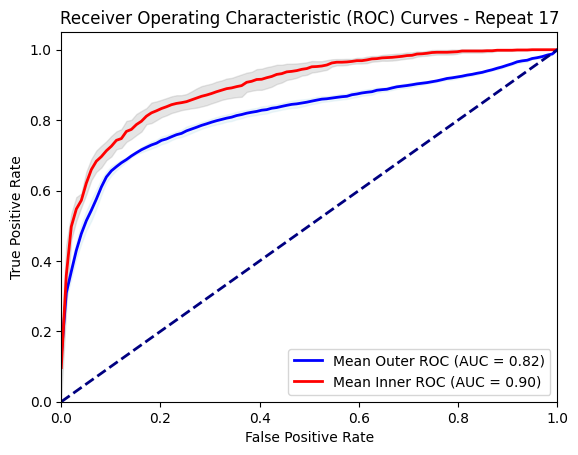

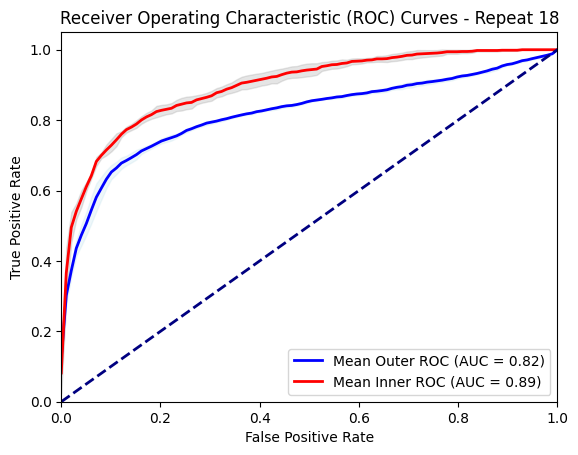

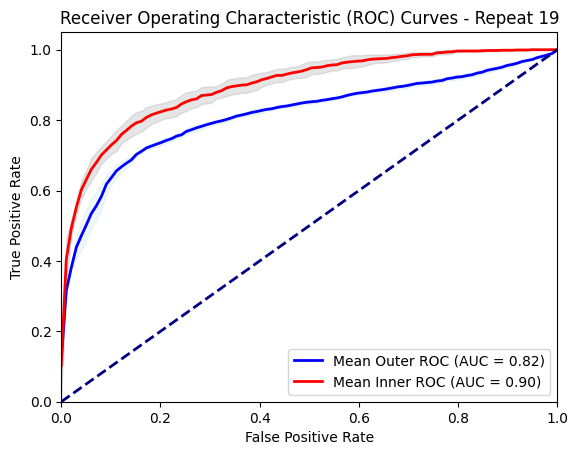

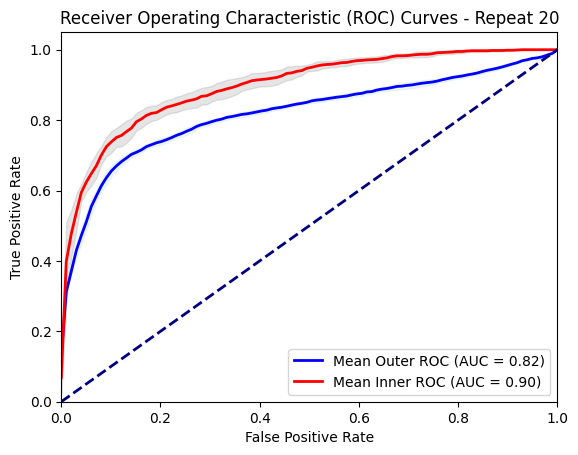

""


In [71]:
# No of time Exoeriment is repeated 
repeat_times = 20
# No of miRNAs need to be consider
no_of_miRNA = 24
# no of epoches in the experiment
iteration = 1500  
# Parameter grid for Ridge Classifier
# param_grid = {'alpha': [  150, 160, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280]}
param_grid = {'alpha': [0.001 ,0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 180, 190, 200, 210, 220, 230]}
# param_grid = {'alpha': [0.001 ,0.01, 0.1, 1, 10]}

# Define the cv Splits in inner and outer loop 
outer_cv_splits = 5
inner_cv_splits  = 4


inner_loop_auc =[]
inner_loop_accuracy = []
outer_loop_auc = []
outer_loop_accuracy = []
best_alpha_inner_cv = []
repeat_no = []

# Repeat the experiment repeat times times
for experiment in range(1, repeat_times +1):

    # in every repeat a new random number is generated and based on that random state is selected for splitting just to make sure to increase random selection in outer test set 
    random_number = random.randint(1, 100)  
    outer_cv = StratifiedKFold(n_splits = outer_cv_splits, shuffle = True, random_state = experiment + random_number)

    for outer_train_index, outer_test_index in outer_cv.split(X_original_norm, y_original_norm):

        

        X_outer_train, X_outer_test = X_original_norm[outer_train_index], X_original_norm[outer_test_index]
        y_outer_train, y_outer_test = y_original_norm[outer_train_index], y_original_norm[outer_test_index]

        
        # train the model with 80 % of the original dataset
                
        cgan = cGAN1(out_shape = no_of_miRNA)
        y_outer_train_1 = y_outer_train.reshape(-1,1)
        pos_index = np.where( y_outer_train_1 == 1)[0]
        neg_index = np.where( y_outer_train_1 == 0)[0]
        cgan.train(X_outer_train, y_outer_train, pos_index, neg_index, epochs = iteration)


        # Defining a random noise according to the no of new samples generated
        noise = np.random.normal(0, 1, (1000, 32))
        
        # To generate 500 instances with class value 0 
        sampled_labels = np.zeros(1000).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])
        gen_df_zeros = pd.DataFrame(data = gen_samples, columns = X_pd.columns)
        gen_df_zeros['Class'] = 0
        
        # To generate 500 instances with class value 1 
        sampled_labels_2 = np.ones(1000).reshape(-1, 1)
        gen_samples_2 = cgan.generator.predict([noise, sampled_labels_2])
        gen_df_ones = pd.DataFrame(data = gen_samples_2, columns = X_pd.columns)
        gen_df_ones['Class'] = 1

        # Combining the generated datasets for zero and ones

        combine_df_generated = pd.concat([gen_df_ones, gen_df_zeros], ignore_index=True, sort=False)
        combine_df_generated = combine_df_generated.sample(frac=1).reset_index(drop=True)

        X_generated = combine_df_generated.drop('Class', axis = 1)
        y_generated = combine_df_generated['Class']

        # normalization

        # define normalization function everytime
        scaler = StandardScaler()
      
        X_generated_norm = scaler.fit_transform(X_generated)
        y_generated_norm =  y_generated.values

        # Combine 80% of original data with generated data for inner loop
        X_combined = np.vstack((X_outer_train, X_generated_norm))
        y_combined = np.concatenate((y_outer_train, y_generated_norm))

        # #Exterimrnt with inner CV 
      

        # # Generate a random number between 1 and 100
        random_number = random.randint(1, 100)
        inner_cv = StratifiedKFold(n_splits = inner_cv_splits, shuffle = True, random_state = random_number + experiment)

        inner_tprs = []
        inner_aucs = []
        inner_acc = []
        mean_fpr = np.linspace(0, 1, 100)
        best_model = None
        tpr_list = []
        best_alpha = None
        best_auc =0
        


        for train_idx, test_idx in inner_cv.split(X_combined, y_combined):
            X_train, X_test = X_combined[train_idx], X_combined[test_idx]
            y_train, y_test = y_combined[train_idx], y_combined[test_idx]

            # Grid search for hyperparameter tuning
            grid_search = GridSearchCV(RidgeClassifier(), param_grid, cv = inner_cv_splits, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            best_model_inner = grid_search.best_estimator_
            best_alpha = grid_search.best_params_['alpha']
            # best_alphas.append(best_alpha)

            # Make predictions
            y_inner_pred = best_model_inner.predict(X_test)
            y_inner_pred_prob = best_model_inner.decision_function(X_test)

            # Calculate and store metrics
            auc_score = roc_auc_score(y_test, y_inner_pred_prob)
            accuracy = accuracy_score(y_test, y_inner_pred)
            inner_aucs.append(auc_score)
            inner_acc.append(accuracy)
            fpr, tpr, _ = roc_curve(y_test, y_inner_pred_prob)
            tpr_list.append(np.interp(mean_fpr, fpr, tpr))
            # Update best model if current model has a higher AUC
            if auc_score > best_auc:
                best_auc = auc_score
                best_model = best_model_inner
                best_alpha = grid_search.best_params_['alpha']
    
        mean_inner_tpr = np.mean(tpr_list, axis=0)
        std_inner_tpr = np.std(tpr_list, axis=0)
        mean_inner_auc = np.mean(inner_aucs)
        mean_inner_acc = np.mean(inner_acc)

        # # Plot ROC curve
        plt.plot(mean_fpr, mean_inner_tpr, color='red', lw=2, label = f'ROC for Inner Loop = {mean_inner_auc:.2f})')
        plt.fill_between(mean_fpr, mean_inner_tpr - std_inner_tpr, mean_inner_tpr + std_inner_tpr, color='lightblue', alpha=0.2)

        inner_loop_auc.append(mean_inner_auc)
        inner_loop_accuracy.append(mean_inner_acc)
        best_alpha_inner_cv.append(best_alpha)

        # Now the outer loo test values are tested on the best model 

        y_outer_pred = best_model.predict(X_outer_test)
                    #  best_model.predict(X_test)
        y_outer_pred_prob =  best_model.decision_function (X_outer_test)

        # Calculate and store metrics for outer test 
        auc_score_outer = roc_auc_score(y_outer_test, y_outer_pred_prob)
        accuracy_outer = accuracy_score(y_outer_test, y_outer_pred)
        outer_fpr, outer_tpr, _ = roc_curve(y_outer_test, y_outer_pred_prob)
        
        # plotting ROC Curve for outer test values 
        plt.plot(outer_fpr, outer_tpr, color='blue', lw=2, label = f'ROC for outer Loop (test) = {auc_score_outer:.2f})')

        outer_loop_auc.append(auc_score_outer)
        outer_loop_accuracy.append(accuracy_outer)


    
        # Plot ROC curve details
        plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves for each fold- Repeat {experiment}')
        plt.legend()
        plt.show()

        repeat_no.append(experiment)

results_df = pd.DataFrame({ 'Repeat': repeat_no,
                            'Best Alpha': best_alpha_inner_cv, 
                            'Outer Accuracy': outer_loop_accuracy
                            'Inner Accuracy': inner_loop_accuracy, 
                            'Outer AUC': outer_loop_auc,
                            'Inner AUC': inner_loop_auc })


Now Mean AUC for inner CV and outer loop

In [6]:
results_df

,Repeat,Fold,Best Alpha,Outer Accuracy,Inner Accuracy,Outer AUC,Inner AUC
0,1,1,160,0.770734,0.858280,0.819985,0.919774
1,1,2,160,0.772510,0.851675,0.826690,0.925507
2,1,3,160,0.774515,0.832536,0.827497,0.896152
3,1,4,160,0.786067,0.818182,0.837867,0.884022
4,1,5,160,0.788061,0.826156,0.833981,0.908888
...,...,...,...,...,...,...,...
95,20,1,160,0.777113,0.850318,0.828823,0.903548
96,20,2,160,0.772519,0.832536,0.824042,0.913353
97,20,3,160,0.778093,0.822967,0.830172,0.900345
98,20,4,160,0.781280,0.822967,0.836825,0.896486


In [7]:
outer_AUC = results_df['Outer AUC']
Outer_auc_mean = outer_AUC.mean()
Outer_auc_std = outer_AUC.std()


inner_AUC = results_df['Inner AUC']
Inner_auc_mean = inner_AUC.mean()
Inner_auc_std = inner_AUC.std()


print( 'Outer Loop AUC:', Outer_auc_mean, Outer_auc_std )
print( 'Inner Loop AUC:', Inner_auc_mean, Inner_auc_std )



Outer Loop AUC: 0.8288163958700001 0.00535243134453449
Inner Loop AUC: 0.9074465887500004 0.010545019216646098
